In [1]:
%matplotlib inline
import numpy as np
from pylab import *

In [6]:
#
#  set parameter values
#
sigma  = 3.50            # risk aversion              
beta   = 0.98            # subjective discount factor 
prob   = np.array([[0.8, 0.2],[0.5, 0.5]]) # prob(i,j) = probability (s(t+1)=sj | s(t) = si)
delta  = 0.97            # 1 - depreciation
A      = 1.00            # production technology
alpha  = 0.25            # capital's share of income
theta  = 0.05            # non-rental income if unemployed is theta*wage
Kstart = 10.0            # initial value for aggregate capital stock
g      = 0.20            # relaxation parameter
#
#   form capital grid
#   
maxkap = 20.0                      # maximum value of capital grid   
inckap = 0.025                   # size of capital grid increments
nkap   = int(np.round(maxkap/inckap+1))  # number of grid points
#
#   calculate aggregate labor supply
#
D = np.zeros((len(prob),len(prob)))
[ed,ev] = np.linalg.eig(prob)
emax = np.amax(np.diag(ed))
inmax = np.argmax(np.diag(ed))

if emax!=1.0:
    print 'are you sure the matrix prob is correct?'

D[inmax,inmax] = emax;
pinf = np.dot(np.dot(ev,D),np.linalg.inv(ev))
pempl = pinf[inmax,inmax]
N = 1.0*pempl + theta*(1.0-pempl)
#
#   loop to find fixed point for agregate capital stock
#
liter   = 1
maxiter = 50
toler   = 0.001
metric  = 10
K = Kstart
print 'ITERATING ON K'
print ''
print '    liter     metric     meanK      Kold'

while metric > toler and liter <= maxiter:
    #
    #  calculate rental rate of capital and wage
    #
    wage = (1.0-alpha)*A*K**(alpha)*N**(-alpha)
    rent = (alpha)*A*K**(alpha-1.0)*N**(1.0-alpha)
    # 
    # tabulate the utility function such that for zero or negative
    #  consumption utility remains a large negative number so that
    #  such values will never be chosen as utility maximizing      
    #
    util1 = -10000.0*np.ones((nkap,nkap)) #utility when employed
    util2 = -10000.0*np.ones((nkap,nkap)) #utility when unemployed

    for i in range(0,nkap):
        kap=i*inckap
        for j in range(0,nkap): 
            kapp = j*inckap
            cons1 = wage + (rent + delta)*kap - kapp #consumption employed
            if cons1 > 0.0:
                if sigma==1.0:
                    util1[j,i] = np.log(cons1)
                else:
                    util1[j,i] = cons1**(1.0-sigma)/(1.0-sigma)
        
            cons2 = theta*wage + (rent + delta)*kap - kapp #consumption unemployed
            if cons2 > 0.0:
                if sigma==1.0:
                    util2[j,i] = np.log(cons2)
                else:
                    util2[j,i] = cons2**(1.0-sigma)/(1.0-sigma)


    # initialize some variables
    #
    v = np.zeros((nkap,2))
    decis = np.zeros((nkap,2))
    test1 = 10.0
    test2 = 10.0
    [rs,cs] = util1.shape
    r1 = np.empty((rs,cs))
    r2 = np.empty((rs,cs))
    #
    #  iterate on Bellman's equation and get the decision 
    #  rules and the value function at the optimum         
    #
    while test1 != False or test2 > 0.1:
        for i in range(0,cs):
            #Bellman employed
            r1[:,i] = util1[:,i] + beta*(prob[0,0]*v[:,0] + prob[0,1]*v[:,1])
            #Bellman unemployed
            r2[:,i] = util2[:,i] + beta*(prob[1,0]*v[:,0] + prob[1,1]*v[:,1])
    
        #find optimal decision
        # max value - employed
        tv1 = np.amax(r1,0) 
        # max position - employed
        tdecis1 = np.argmax(r1, axis=0)
        # max value - unemployed
        tv2 = np.amax(r2,0)
        # max position - unemployed
        tdecis2 = np.argmax(r2, axis=0)

        #stack into one
        tdecis = np.vstack([[tdecis1.T],[tdecis2.T]]).T
        tv = np.vstack([[tv1],[tv2]]).T

        # iterate until not improving value any more
        # not changing position
        test1 = np.any(tdecis-decis)
        # not changing value
        test2 = np.max((np.max(np.abs(tv-v),axis=0)))
        v = tv
        decis = tdecis

    # transform choice into asset level
    decis=decis*inckap
    #
    #   form transition matrix
    #   trans is the transition matrix from state at t (row)
    #   to the state at t+1 (column) 
    # 
    g2 = np.zeros((cs,cs)) # unemployed
    g1 = np.zeros((cs,cs)) # employed
    for i in range (0,cs):
        g1[i,tdecis1[i]] = 1.0 # set to one where utility maximised (zero out choices which are not maximising)
        g2[i,tdecis2[i]] = 1.0

    # matrix of transition probabilities
    trans = np.vstack([np.hstack([prob[0,0]*g1, prob[0,1]*g1]),np.hstack([prob[1,0]*g2, prob[1,1]*g2])]).T
    # initial guess for matrix of stationary probabilites 
    probst = (1.0/(2.0*nkap))*np.ones((2.0*nkap,1.0))
    test = 1.0  
    while test > 10**(-8):
        # iteration until probabilities stop changing (stationary probabilities)
        probst1 = np.dot(trans,probst)
        test = np.max(np.abs(probst1-probst))
        probst = probst1 
        
    #
    #   vectorize the decision rule to be conformable with probst
    #   calculate new aggregate asset meanA 
    #
    kk = decis.flatten('F')
    meanK = np.dot(probst.T,kk)
    #
    #  calculate measure over (k,s) pairs
    #  lambda has same dimensions as decis
    #
    Lambda = np.zeros((cs,2))
    Lambda = np.hstack([probst[0:cs],probst[cs:]])

    #
    #   calculate stationary distribution of k
    #
    [d1,v1] = np.linalg.eig(prob.T)
    dmax = np.amax(np.diag(d1))
    imax = np.argmax(np.diag(d1))
    probst1 = v1[:,imax]
    ss = np.sum(probst1)
    probk = np.sum(Lambda.T, axis=0).T
    #
    #   form metric and update K
    #
    if K ==10.0:
        Kold = np.array([K])
    else:
        Kold = K
    Knew = g*meanK + (1-g)*Kold
    metric = np.abs((Kold-meanK)/Kold)
    K = Knew
    print [liter, metric[0], meanK[0], Kold[0]]
    liter = liter+1
    
print 'PARAMETER VALUES'
print ''
print '    sigma      beta      delta       A      alpha      theta' 
print [sigma, beta, delta, A, alpha, theta]
print ''
print 'EQUILIBRIUM RESULTS '
print ''
print '   K         N        wage      rent'
print [Kold[0], N, wage[0], rent[0]]
    

ITERATING ON K

    liter     metric     meanK      Kold
[1, 0.15915418566127784, 8.4084581433872216, 10.0]
[2, 0.1178470183843958, 8.5407331373206432, 9.681691628677445]
[3, 0.084582673013016071, 8.6538976369639773, 9.4534999304060854]
[4, 0.060480986024788679, 8.7314946215684461, 9.2935794717176652]
[5, 0.041477366085214358, 8.8003520635174741, 9.1811625016878224]
[6, 0.02829634620609725, 8.8473621701310297, 9.1050004140537535]
[7, 0.018859181648701911, 8.8827316778374215, 9.0534727652692091]
[8, 0.013334095597254226, 8.8990600120400529, 9.0193245477828512]
[9, 0.0098494908992870934, 8.9066727944732502, 8.995271640634293]
[10, 0.0069324130393513721, 8.9153157737473236, 8.9775518714020848]
[11, 0.0025260380924554014, 8.9424584560176577, 8.9651046518711333]
[12, 0.0035596909748439537, 8.9286785332744412, 8.9605754127004396]
[13, 0.0029733744414624638, 8.9275718591755293, 8.9541960368152402]
[14, 0.0014325808202834786, 8.936051220041147, 8.9488712012872984]
[15, 0.00013324159027503345, 

In [7]:
def markov(T,n=100,s0=0,V=np.array([range(0,prob.shape[0])])):
    '''generates a simulation from a Markov chain of dimension the size of T
    T is transition matrix
    n is number of periods to simulate
    s0 is initial state
    V is the quantity corresponding to each state
    state is a matrix recording the number of the realized state at time t
    '''
    [r,c] = T.shape
    assert r==c, "Error in markov function: transition matrix must be square"
    for k in range(0,r):
        if sum(T[k,:])!=1:
            print "Error in markov function: row " + str(k) + " does not sum to one"
            print "Normalising..."
            T[k,:]=T[k,:]/sum(T[k,:])
    [v1, v2] = V.shape
    if v2 == 1 and v2 == r:
        print 'Transposing state valuation vector'
        V=V.T
        
    assert v1==1, "Error in markov function: state value vector V must be 1 x " + str(r)
    assert v2==r, "Error in markov function: state value vector V must be 1 x " + str(r)
    if s0<0:
        print "Error in markov function: initial state " + num2str(s0) + " is out of range"
        print "Initial state defaulting to 0"
        s0=0
    
    np.random.seed(42)
    X = np.random.rand(n-1,1)
    s = np.array(np.zeros((r,1)))
    s[s0] = 1
    # cumulative transition probabilities
    cum = np.dot(T,np.triu(np.ones((T.shape))))
    state = np.array(np.zeros((r,len(X))))
    for k in range(0,len(X)):
        state[:,k] = s.T
        ppi = np.append([0.0],[np.dot(s.T,cum)])
        s = ((X[k]<=ppi[1:r+1]).astype(int)*(X[k]>ppi[0:r]).astype(int)).T
    chain = np.array(np.dot(V,state),dtype=int)


    return chain, state

SIMULATING LIFE HISTORY


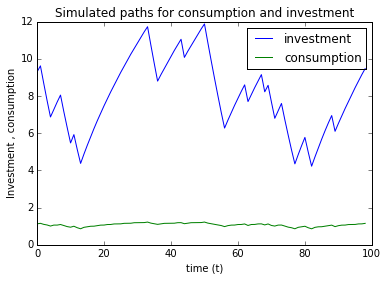

Covariance matrix
[[ 0.00749322  0.1675481 ]
 [ 0.1675481   3.93226509]]


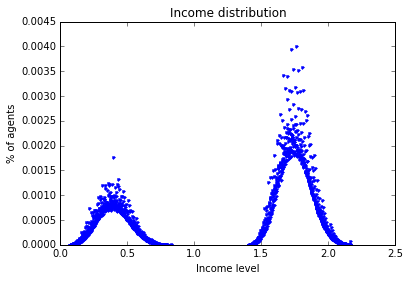

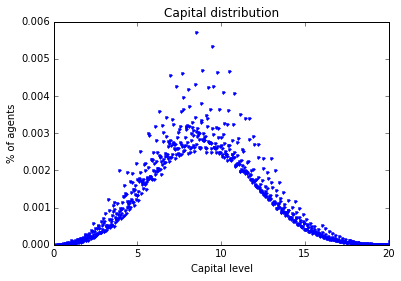

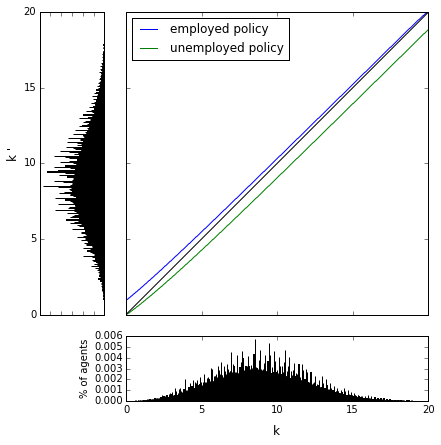

In [8]:
#
#    simulate life histories of the agent
#
print 'SIMULATING LIFE HISTORY'
k = Kold                  # initial level of capital 
n = 100                # number of periods to simulate
s0 = 0                 # initial state 
hist = np.zeros((n-1,2))
cons = np.zeros((n-1,1))
invest = np.zeros((n-1,1))
grid = np.linspace(0.0,maxkap,(maxkap-0.0)/inckap + 1).T
[chain,state] = markov(prob,n,s0)
for i in range(0,n-1):
    #history of shocks
    hist[i,:] = np.append(k,chain[0][i])
    #
    I1 = np.int(np.round(k/inckap))
    I2 = np.int(np.round(k/inckap))+1
    if I1==0:
        I1 = 1
        print "NB. I1 = 0"
    if I2>nkap:
        I2 = nkap
        print "NB. I2 > nkap" 
    weight = (grid[I2] - k)/inckap
    kprime = weight*(decis[I1,chain[0][i]]) +  (1-weight)*(decis[I2,chain[0][i]])
    if chain[0][i] == 0:
        cons[i] = wage + (rent + delta)*k - kprime
    else:
        cons[i] = wage*theta + (rent + delta)*k - kprime

    k = kprime
    invest[i] = kprime

#Plot stuff
t = np.arange(0, n-1, 1.0)
plot(t, invest, label = 'investment')
plot(t, cons, label = 'consumption')

xlabel('time (t)')
ylabel('Investment , consumption')
title('Simulated paths for consumption and investment')
legend(loc ='upper right')
show()

print 'Covariance matrix'
print np.cov(np.hstack([cons, invest]).T)
#
#     calculate income distribution
#
income = np.hstack([(rent*grid + wage),(rent*grid + wage*theta)])
pinc = np.sort(income)
index = np.argsort(income)
pLambda = Lambda.flatten('F')
plot(pinc, pLambda[index], '.')
xlabel('Income level')
ylabel('% of agents')
title('Income distribution')
show()

#
#    calculate capital distribution
#
plot(grid, probk, '.')
xlabel('Capital level')
ylabel('% of agents')
title('Capital distribution')
show()

#
#   Policy rules and asset distribution
#

# start with a rectangular figure
plt.figure(figsize=(6, 6))

# define the axes positions
left = bottom = 0.1
width = height = 0.7

ax_main = plt.axes([left, bottom, width, height])
ax_bottom = plt.axes([left, bottom - 0.2, width, 0.15])
ax_left = plt.axes([left - 0.2, bottom, 0.15, height])
# plot the data points
ax_main.plot(grid, decis[:,0], label='employed policy')
ax_main.plot(grid, decis[:,1], label='unemployed policy')
ax_main.plot(grid, grid, 'black')

#work out savings
#savings = np.hstack([(grid),(grid)])
#psav = np.sort(savings)
#indexsav = np.argsort(savings)
# finally plot 1d histograms for the bottom and left axes.
#ax_bottom.bar(psav, pLambda[indexsav],width = 0.01)
ax_bottom.bar(grid, probk,width = 0.01)
#ax_left.barh(psav, pLambda[index], 0.01)
ax_left.barh(grid, probk,0.01)

# make all the limits consistent
ax_bottom.set_xlim(0.0, maxkap )
ax_left.set_ylim(0.0, maxkap)
ax_main.set_xlim(0.0, maxkap)
ax_main.set_ylim(0.0, maxkap)

# remove the tick labels
#ax_bottom.set_xticklabels([])
ax_main.set_xticklabels([])
ax_main.set_yticklabels([])
ax_left.set_xticklabels([])
#ax_left.set_yticklabels([])
ax_left.invert_xaxis()

# axis titles
ax_bottom.set_title('k')
ax_bottom.title.set_position([0.5,-0.6,0.0,0.4])
ax_left.set_title("k '", rotation=90)
ax_left.title.set_position([-0.4,0.5,1.0,1.0])
ax_bottom.set_ylabel('% of agents')

ax_main.legend(loc='upper left')
plt.draw()